# Joint Intent Classification and Slot Filliing with Transformers

**Goal**
* Fine-tune a pretrained transformer-based neural network model to convert a user qeury expressed in English into a representation that is structured enough to be processed by an automated service.

Here is an example of interpretation computed by such a Natural Language Understanding system:
    
    >>> nlu(''क्या आज मनाली में बर्फबारी होगी?'",
            tokenizer, joint_model, intent_names, slot_names)
    {
        {'intent': 'GetWeather',        
 'slots': {'condition_description': 'snowfalls',        
  'city':Manalili'        ,
  'timeRange': 'today?'}}
  nge
     
We will shw hhow to train a such "sequence classification" and "token classification" joint model on a voice command dataset published by snips.ai. This notebook is a partial reproduction of some of the results presented in this paper: BERT for Joint Intent Classification and Shot Filling, Qian Chen, Zhu Zhuo, Wen Wang [link](https://arxiv.org/abs/1902.10909).

In [ ]:
!pip install transformers

In [2]:
# Load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from pathlib import Path
from transformers import BertTokenizer, TFBertModel
from urllib.request import urlretrieve

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam

## The data

We will use a speed command dataset collected, annotated and published by French startup snips.ai (bought in 2019 by Audio device manufacturer Sonos). The original dataset comes in [YAML format with inline markdown annotations](https://snips-nlu.readthedocs.io/en/latest/dataset.html). Instead, we will use a preprocessed variant with token level B-I-O annotations closer to the representation our model will predict. This variant of the snips dataset was prepared by [Su Zhu](https://github.com/sz128).

Let's have a look at the first lines from the training set.

In [5]:
lines_train = Path('/kaggle/input/softcomp/train.txt').read_text('utf-8').strip().splitlines()

In [6]:
def parse_line(line):
    utterance_data, intent_label = line.split(" <=> ")
    items = utterance_data.split()
    words = [item.rsplit(':', 1)[0] for item in items]
    word_labels = [item.rsplit(':', 1)[1] for item in items]
    return {
        'intent_label': intent_label,
        'words': " ".join(words),
        'words_label': " ".join(word_labels),
        'length': len(words)
    }

In [7]:
parse_line(lines_train[0])

{'intent_label': 'AddToPlaylist',
 'words': 'Add Don and Sherri to my Meditate to Sounds of Nature playlist',
 'words_label': 'O B-entity_name I-entity_name I-entity_name O B-playlist_owner B-playlist I-playlist I-playlist I-playlist I-playlist O',
 'length': 12}

This utterance is a voice command of type "AddToPlayist" with annotations:
* an entity-name: "Don and Sherri",
* a playlist: "Medidate to Sounds of Nature".

The goal of this project is to build a baseline Natural Understanding model to analyse such voice commands and predict:
* the intent of the speaker: the sentence level class label ("AddToPlaylist");
* extract the interesting slots (typed named entities) from the sentence by performing word level classification using the B-I-O tags as target classes. This second task is often referred to as "NER" (Named Entity Recognition) in the NLP litterature. Alternatively, this is also known as "slot filling" when we expect a fixed set of named entity per sentence of a given class.

The list of possible classes for the sentence level and the word level classification problems are given as:

"POI" stands for "Point of Interest". Let's parse all the lines and store the results in a Pandas dataframes.

In [8]:
parsed = [parse_line(line) for line in lines_train]
df_train = pd.DataFrame([p for p in parsed if p is not None])

In [9]:
# Print some lines of the training set
df_train.head(5)

,intent_label,words,words_label,length
0,AddToPlaylist,Add Don and Sherri to my Meditate to Sounds of...,O B-entity_name I-entity_name I-entity_name O ...,12
1,AddToPlaylist,put United Abominations onto my rare groove pl...,O B-entity_name I-entity_name O B-playlist_own...,8
2,AddToPlaylist,add the tune by misato watanabe to the Trapeo ...,O O B-music_item O B-artist I-artist O O B-pla...,10
3,AddToPlaylist,add this artist to my this is miguel bosé play...,O O B-music_item O B-playlist_owner B-playlist...,10
4,AddToPlaylist,add heresy and the hotel choir to the evening ...,O B-entity_name I-entity_name I-entity_name I-...,11


In [10]:
# Count the number of lines by intent label
df_train.intent_label.value_counts()

intent_label
GetWeather              1900
PlayMusic               1900
BookRestaurant          1873
SearchScreeningEvent    1859
RateBook                1856
SearchCreativeWork      1854
AddToPlaylist           1842
Name: count, dtype: int64

array([[<Axes: title={'center': 'length'}>]], dtype=object)

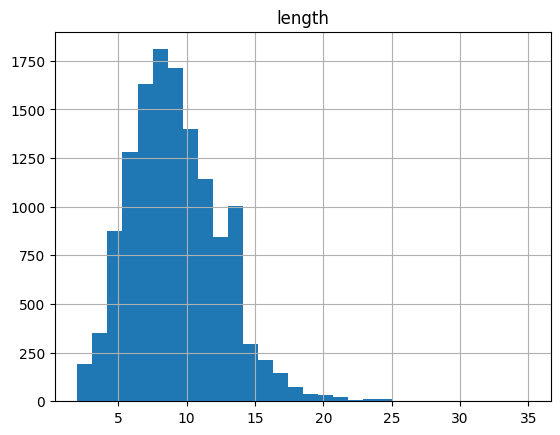

In [11]:
# Histogram of sentence lengths
df_train.hist('length', bins=30)

In [12]:
# Get validation and test set
lines_validation = Path('/kaggle/input/softcomp/valid.txt').read_text('utf-8').strip().splitlines()
lines_test = Path('/kaggle/input/softcomp/test.txt').read_text('utf-8').strip().splitlines()
lines_train=Path('/kaggle/input/softcomp/train.txt').read_text('utf-8').strip().splitlines()
df_validation = pd.DataFrame([parse_line(line) for line in lines_validation])
df_test = pd.DataFrame([parse_line(line) for line in lines_test])

## Intent classification (sentence level)

Let's ignore the slot filling task for now and let's try to build a sentence level classifier by fine-tuning a pre-trained Transformer-based model using the `huggingface/transformers` package that provides both Tensorflow/Keras and Pytorch APIs.

### The BERT tokenizer

First let's load a pre-trained tokenizer and test it on a test sentence from the training set.

In [13]:
from transformers import BertTokenizer, TFBertModel

# Specify the path to your local model directory
model_path = "/kaggle/input/bert/tensorflow2/default/1/bert"

# Load the tokenizer and model from the local directory
tokenizer = BertTokenizer.from_pretrained(model_path)
model = TFBertModel.from_pretrained(model_path)

Some layers from the model checkpoint at /kaggle/input/bert/tensorflow2/default/1/bert were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at /kaggle/input/bert/tensorflow2/default/1/bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
first_sentence = df_train.iloc[0]['words']
print(first_sentence)

Add Don and Sherri to my Meditate to Sounds of Nature playlist


In [15]:
tokenizer.tokenize(first_sentence)

['Ad',
 '##d',
 'Don',
 'and',
 'She',
 '##rri',
 'to',
 'my',
 'Me',
 '##dit',
 '##ate',
 'to',
 'Sounds',
 'of',
 'Nature',
 'play',
 '##list']

Notive that BERT uses subword tokens. So the length of the tokenized sentence is likely to be larger than the number of words in the sentence. It is particularly interesting to use subword tokenization sentence for general purpose language models such as BERT because it should be possible to generalize the model and then to fine-tuned it to be a specialized one.

Each token string is mapped to a unique integer id that makes it fast to lookup the right column in the input layer token embedding.

To perform transfer learning, we will need to work with padded sequences. So, they all have the same sizes. The above histograms, shows that after tokenization, $43$ tokens are enough to represent all the voice commands in the training set.

The mapping can be introspected in the `tokenizer.vocab` attribute.

In [16]:
print(f'Vocabulary size: {tokenizer.vocab_size} words.')

Vocabulary size: 28996 words.


In [17]:
def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length),
                         dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    
    return {'input_ids': token_ids, 'attention_mask': attention_masks}

In [18]:
encoded_train = encode_dataset(tokenizer, df_train['words'], 45)
encoded_validation = encode_dataset(tokenizer, df_validation['words'], 45)
encoded_test = encode_dataset(tokenizer, df_test['words'], 45)

In [19]:
encoded_train['input_ids']

array([[  101, 24930,  1181, ...,     0,     0,     0],
       [  101,  1508,  1244, ...,     0,     0,     0],
       [  101,  5194,  1103, ...,     0,     0,     0],
       ...,
       [  101, 27640,  1116, ...,     0,     0,     0],
       [  101,  5979,  6608, ...,     0,     0,     0],
       [  101,  1327,  2523, ...,     0,     0,     0]], dtype=int32)

In [20]:
encoded_train['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

### Encoding the sequence classification targets

To do so, we build a simple mapping from the auxiliary files.

In [21]:
intent_names = Path('/kaggle/input/softcomp/vocab.intent').read_text('utf-8').split()
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))

In [22]:
intent_map

{'AddToPlaylist': 0,
 'BookRestaurant': 1,
 'GetWeather': 2,
 'PlayMusic': 3,
 'RateBook': 4,
 'SearchCreativeWork': 5,
 'SearchScreeningEvent': 6}

In [23]:
intent_train = df_train['intent_label'].map(intent_map).values
intent_validation = df_validation['intent_label'].map(intent_map).values
intent_test = df_test['intent_label'].map(intent_map).values

### Loading and feeding a pretrained BERT model

Let's load a pretrained BERT model using the [huggingface transformers](https://github.com/huggingface/transformers) package.

In [24]:
from transformers import TFBertModel

# Replace 'bert-base-cased' with your local model path
model_path = "/kaggle/input/bert/tensorflow2/default/1/bert"  # Adjust this path if needed

# Load the model from the local directory
base_bert_model = TFBertModel.from_pretrained(model_path)
base_bert_model.summary()


Some layers from the model checkpoint at /kaggle/input/bert/tensorflow2/default/1/bert were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at /kaggle/input/bert/tensorflow2/default/1/bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108310272 (413.17 MB)
Trainable params: 108310272 (413.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
outputs = base_bert_model(encoded_validation)

The first output of the BERT model is a tensor with shape: `(batch_size, seq_len, output_dim)` which computes features for each token in the input sequence.

Let's build an train a sequece classification model using to predict the intent class. We will use the `self.bert` pretrained model in the `call` method and only consider the pooled features (ignore the token-wise features for now).

In [26]:
# Define IntentClassification model
class IntentClassificationModel(tf.keras.Model):
    def __init__(self, intent_num_labels=None,
                 model_name='/kaggle/input/bert/tensorflow2/default/1/bert',
                 dropout_prob=0.1):
        super().__init__(name='joint_intent_slot')
        # Let's preload the pretrained model BERT in the constructor
        # of our classifier model.
        self.bert = TFBertModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        
        # Define a (Dense) classification layer to compute for each
        # sequence in a batch of samples. The number of output classes
        # is given by the intent_num_labels parameter.
        # Use the default linear activation (no softmax) to compute
        # logits. The softmax normalization will be computed in the
        # loss function instead of the model itself.
        self.intent_classifier = Dense(intent_num_labels)
        
    def call(self, inputs, **kwargs):
        # Extract the features using the pretrained BERT model.
        bert_output = self.bert(inputs, **kwargs)
        
        # The `bert_output` is now an object, so access `pooler_output` directly.
        pooled_output = bert_output.pooler_output  # (batch_size, hidden_size)
    
        # Apply dropout to the pooled output.
        pooled_output = self.dropout(pooled_output, training=kwargs.get('training', False))
        
        # Compute logits using the classifier.
        intent_logits = self.intent_classifier(pooled_output)
        
        return intent_logits


The classification model outputs logits instead of probabilities. The final softmax normalization layer is implicit, that is, included in the loss function instead of the model directly. We need to configure the loss function `SparseCategoricalCrossentropy(from_logits=True)` accordingly.

In [27]:
# Build the model
intent_model = IntentClassificationModel(intent_num_labels=len(intent_map))

intent_model.compile(optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
                     loss=SparseCategoricalCrossentropy(from_logits=True),
                     metrics=[SparseCategoricalAccuracy('accuracy')])

Some layers from the model checkpoint at /kaggle/input/bert/tensorflow2/default/1/bert were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at /kaggle/input/bert/tensorflow2/default/1/bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [28]:
# Train the model
history = intent_model.fit(encoded_train, intent_train,
                           epochs=2, batch_size=32,
                           validation_data=(encoded_validation, intent_validation))

Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:1295: UserWarning: Layer 'joint_intent_slot' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''The following keyword arguments are not supported by this model: ['kwargs'].''
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'joint_intent_slot', however the layer does not have a `build()` method implemented and it loo

  3/409 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.1719 - loss: 2.5388   

I0000 00:00:1731852654.996674      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


407/409 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1745 - loss: 2.0616

W0000 00:00:1731852672.214821      95 assert_op.cc:38] Ignoring Assert operator joint_intent_slot_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert


409/409 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1747 - loss: 2.0610

W0000 00:00:1731852677.899957      95 assert_op.cc:38] Ignoring Assert operator joint_intent_slot_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert
W0000 00:00:1731852680.773373      94 assert_op.cc:38] Ignoring Assert operator joint_intent_slot_1/tf_bert_model_2/bert/embeddings/assert_less/Assert/Assert


409/409 ━━━━━━━━━━━━━━━━━━━━ 43s 67ms/step - accuracy: 0.1748 - loss: 2.0608 - val_accuracy: 0.2957 - val_loss: 1.8767
Epoch 2/2
409/409 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.3306 - loss: 1.8490 - val_accuracy: 0.3714 - val_loss: 1.8110


In [31]:
def classify(text, tokenizerzer, model, intent_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :] # Batch size = 1
    class_id = model(inputs).numpy().argmax(axis=1)[0]
    return intent_names[class_id]

In [32]:
# Example of classification
classify('Will it snow tomorrow in Paris?',
         tokenizer, intent_model, intent_names)

'GetWeather'

## Join intent classification and slot filling

Let's now refine our natural language understanding system by trying to retrieve the important structured elements of each voice command. To do so, we will perform word level (or token level) classification of the BIO labels. Since we have word level tags but BERT uses a wordpiece tokenizer, we need to align the BIO labels with the BERT tokens. Let's load the list of possible word token labels and augment it with an additional padding label to be able to ignore special tokens.

In [33]:
slot_names = ["[PAD]"]
slot_names += Path('/kaggle/input/softcomp/vocab.slot').read_text('utf-8').strip().splitlines()

slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)

The following function generates token-aligned integer labels from the BIO word-level annotations. In particular, if a specific word is too long to be represented as a single token, we expand its label for all the tokens of that word while taking care of using "B-" labels only for the first token and then use "I-" for the matching slot type for subsequent tokens of the same word.

In [34]:
def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map, max_length):
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, (text_sequence, word_labels) in enumerate(
            zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.append(slot_map[word_label])
            expand_label = word_label.replace("B-", "I-")
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
    return encoded

In [35]:
slot_train = encode_token_labels(df_train['words'], df_train['words_label'], tokenizer, slot_map, 45)
slot_validation = encode_token_labels(df_validation['words'], df_validation['words_label'], tokenizer, slot_map, 45)
slot_test = encode_token_labels(df_test['words'], df_test['words_label'], tokenizer, slot_map, 45)

Note that the special tokens such as "[PAD]" and "[SEP]" and all padded positions receive a $0$ label.

In [36]:
# Define JointIntentAndSlotFilling model
class JointIntentAndSlotFillingModel(tf.keras.Model):

    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="/kaggle/input/bert/tensorflow2/default/1/bert", dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFBertModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels,
                                       name="intent_classifier")
        self.slot_classifier = Dense(slot_num_labels,
                                     name="slot_classifier")

    def call(self, inputs, **kwargs):
        # Get the output from the BERT model, which returns an object.
        bert_output = self.bert(inputs, **kwargs)
        
        # Extract `last_hidden_state` and `pooler_output` from the output object.
        sequence_output = bert_output.last_hidden_state  # (batch_size, max_length, output_dim)
        pooled_output = bert_output.pooler_output        # (batch_size, hidden_size)
    
        # Apply dropout to the sequence output for slot classification.
        sequence_output = self.dropout(sequence_output, training=kwargs.get("training", False))
        slot_logits = self.slot_classifier(sequence_output)
    
        # Apply dropout to the pooled output for intent classification.
        pooled_output = self.dropout(pooled_output, training=kwargs.get("training", False))
        intent_logits = self.intent_classifier(pooled_output)
    
        return slot_logits, intent_logits

In [37]:
joint_model = JointIntentAndSlotFillingModel(
    intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))

# Define one classification loss for each output:
opt = Adam(learning_rate=3e-5, epsilon=1e-08)
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]
metrics = [SparseCategoricalAccuracy('accuracy'),SparseCategoricalAccuracy('accuracy')]
joint_model.compile(optimizer=opt, loss=losses, metrics=metrics)

Some layers from the model checkpoint at /kaggle/input/bert/tensorflow2/default/1/bert were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at /kaggle/input/bert/tensorflow2/default/1/bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [44]:
history = joint_model.fit(
    encoded_train, (slot_train, intent_train),
    validation_data=(encoded_validation, (slot_validation, intent_validation)),
    epochs=20, batch_size=32)

Epoch 1/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8147 - accuracy_1: 0.3682 - loss: 3.5977 - val_accuracy: 0.8218 - val_accuracy_1: 0.4129 - val_loss: 3.1166
Epoch 2/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8281 - accuracy_1: 0.4236 - loss: 2.9908 - val_accuracy: 0.8271 - val_accuracy_1: 0.4157 - val_loss: 2.7652
Epoch 3/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8332 - accuracy_1: 0.4490 - loss: 2.6819 - val_accuracy: 0.8342 - val_accuracy_1: 0.4771 - val_loss: 2.5559
Epoch 4/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8418 - accuracy_1: 0.4763 - loss: 2.4899 - val_accuracy: 0.8445 - val_accuracy_1: 0.4486 - val_loss: 2.4106
Epoch 5/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8521 - accuracy_1: 0.5014 - loss: 2.3425 - val_accuracy: 0.8557 - val_accuracy_1: 0.4971 - val_loss: 2.2901
Epoch 6/20
409/409 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.8639 - accuracy_1: 0.5235 - loss: 2.2306 - val_accur

The following function uses our trained model to make prediction on a single text sequence and display both the sequence-wise and the token-wise class labels.

In [45]:
def show_predictions(text, tokenizer, model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]
    print("## Intent:", intent_names[intent_id])
    print("## Slots:")
    for token, slot_id in zip(tokenizer.tokenize(text), slot_ids):
        print(f"{token:>10} : {slot_names[slot_id]}")

## Decoding predictions into structured knowledge

For completeness, here a minimal functional to naively decode the predicted BIO slot ids and convert it into a structured representation for the detected slots as a Python dictionaries.

In [47]:
def decode_predictions(text, tokenizer, intent_names, slot_names,
                       intent_id, slot_ids):
    info = {"intent": intent_names[intent_id]}
    collected_slots = {}
    active_slot_words = []
    active_slot_name = None
    for word in text.split():
        tokens = tokenizer.tokenize(word)
        current_word_slot_ids = slot_ids[:len(tokens)]
        slot_ids = slot_ids[len(tokens):]
        current_word_slot_name = slot_names[current_word_slot_ids[0]]
        if current_word_slot_name == "O":
            if active_slot_name:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = []
                active_slot_name = None
        else:
            # Naive BIO: handling: treat B- and I- the same...
            new_slot_name = current_word_slot_name[2:]
            if active_slot_name is None:
                active_slot_words.append(word)
                active_slot_name = new_slot_name
            elif new_slot_name == active_slot_name:
                active_slot_words.append(word)
            else:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = [word]
                active_slot_name = new_slot_name
    if active_slot_name:
        collected_slots[active_slot_name] = " ".join(active_slot_words)
    info["slots"] = collected_slots
    return info

## Machine Translation Hindi to English


In [48]:

# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer_trans = AutoTokenizer.from_pretrained("TestZee/FineTuned-hindi-to-english-V8")
model_trans = AutoModelForSeq2SeqLM.from_pretrained("TestZee/FineTuned-hindi-to-english-V8")

tokenizer_config.json:   0%|          | 0.00/323 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/813k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.18M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/74.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/302M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

## Inference

In [49]:
def nlu(text, tokenizer, model, intent_names, slot_names):
    tokenized_text = tokenizer_trans(text,return_tensors="pt")
    translated = model_trans.generate(**tokenized_text)
    text = tokenizer_trans.batch_decode(translated, skip_special_tokens=True)[0]
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]

    return decode_predictions(text, tokenizer, intent_names, slot_names,
                              intent_id, slot_ids)

In [52]:
nlu('में इतनी महंगी किताब नहीं खरीद सकता ।',
                 tokenizer, joint_model, intent_names, slot_names)

{'intent': 'RateBook', 'slots': {'sort': 'expensive', 'object_type': 'books.'}}

In [64]:
nlu('क्या आज मनाली में बर्फबारी होगी?',
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'GetWeather',
 'slots': {'condition_description': 'snowfalls',
  'city': 'Nitali',
  'timeRange': 'today?'}}

## Limitations

### Language

BERT is pretrained primarily on English content. It can therefore only extract meaningful features on text written in English.

Note that there exists alternative pretrained model that use a mix of different languages (e.g. [XLM](https://github.com/facebookresearch/XLM/) and others that have been trained on other languages. For instance [CamemBERT](https://camembert-model.fr/) is pretrained on French text. Both kinds of models are available in the transformers package:

https://github.com/huggingface/transformers#model-architectures

The public snips.ai dataset used for fine-tuning is English only. To build a model for another language we would need to collect and annotate a similar corpus with tens of thousands of diverse, representative samples.

### Biases embedded in the pre-trained model

The original data used to pre-trained BERT was collected from the Internet and contains all kinds of data, including offensive and hateful speech.

While using BERT for or voice command understanding system is quite unlikely to be significantly impacted by those biases, it could be a serious problem for other kinds of applications such as Machine Translation for instance.

It is therefore strongly recommended to spend time auditing the biases that are embedded in such pre-trained models before deciding to deploy system that derive from them.

### Computational ressources

The original BERT model has many parameters which uses a lot of memory and can be prohibitive to deploy on small devices such as mobile phones. It is also very computationally intensive and typically requires powerful GPUs or TPUs to process text data at a reasonable speed (both for training and at inference time).

Designing alternative architectures with fewer parameters or more efficient training and inference procedures is still a very active area of research.

Depending of on the problems, it might be the case that simpler architectures based on convolutional neural networks and LSTMs might offer a better speed / accuracy trade-off.